In [38]:
import hashlib
import math
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import pandas as pd

In [2]:
train_dir = Path('./train_dir/simpsons_dataset/')
test_dir = Path('./test_dir/kaggle_simpson_testset/')


def list_of_files(dir, with_aug=True):
    filename = '*/*.jpg'
    if with_aug:
        filename = '*/*.*'
    files_training = glob(os.path.join(dir, filename))
    print('Number of images in Training dir:', len(files_training))
    return files_training


list_of_files(train_dir)

Number of images in Training dir: 31015


['train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0000.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0001.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0002.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0003.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0004.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0005.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0006.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0007.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0008.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0009.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0010.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0011.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0012.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0013.jpg',
 'train_dir\\simpson

In [3]:
CLASS_NAMES = []
for i in os.listdir(train_dir):
    if not i.startswith('.'):
        CLASS_NAMES.append(i)

In [4]:
def generate_md5_hash(file_path):
    with open(file_path, 'rb') as file:
        # Read the file contents
        data = file.read()

        # Calculate the MD5 hash
        md5_hash = hashlib.md5(data).hexdigest()

        return md5_hash

In [5]:
def remove_duplicate_from_dir(dir):
    hashes = {}
    files = glob(os.path.join(dir, '*.jpg'))
    for path in files:
        hash_image = generate_md5_hash(path)
        if hash_image not in hashes:
            hashes[hash_image] = []
        hashes[hash_image].append(path)
    duplicate_counter = 0
    for hash, images in hashes.items():
        if len(images) > 1:
            for image in images[1:]:
                os.remove(image)
                duplicate_counter += 1
    if duplicate_counter > 0:
        print(f"removed {duplicate_counter} duplicate from {dir}")

In [6]:
for dir in glob(os.path.join(train_dir, "*")):
    remove_duplicate_from_dir(dir)
for dir in glob(os.path.join(test_dir, "*")):
    remove_duplicate_from_dir(dir)

In [7]:
def items_per_class(dir):
    class_quantity = {i: 0 for i in CLASS_NAMES}
    for class_name in CLASS_NAMES:
        if not class_name.startswith('.'):
            class_path = os.path.join(dir, class_name)
            num_images = len(glob(os.path.join(class_path, '*.*')))
            class_quantity[class_name] += num_images
    return class_quantity

Total classes: 42
Items per class:
abraham_grampa_simpson 913
agnes_skinner 504
apu_nahasapeemapetilon 623
barney_gumble 502
bart_simpson 1342
carl_carlson 503
charles_montgomery_burns 1193
chief_wiggum 986
cletus_spuckler 506
comic_book_guy 501
disco_stu 512
edna_krabappel 501
fat_tony 504
gil 504
groundskeeper_willie 501
homer_simpson 2246
kent_brockman 501
krusty_the_clown 1206
lenny_leonard 501
lionel_hutz 192
lisa_simpson 1354
maggie_simpson 503
marge_simpson 1291
martin_prince 505
mayor_quimby 501
milhouse_van_houten 1079
miss_hoover 502
moe_szyslak 1452
ned_flanders 1454
nelson_muntz 501
otto_mann 512
patty_bouvier 504
principal_skinner 1194
professor_john_frink 505
rainier_wolfcastle 506
ralph_wiggum 504
selma_bouvier 503
sideshow_bob 877
sideshow_mel 508
snake_jailbird 505
troy_mcclure 512
waylon_smithers 502


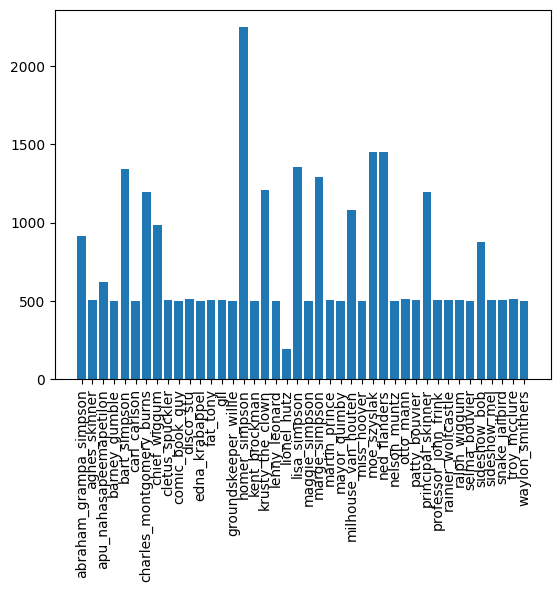

In [8]:
def print_classes_graph(dir):
    class_stat = items_per_class(dir)
    plt.bar(class_stat.keys(), class_stat.values(), align='center')
    plt.xticks(rotation=90)
    print(f"Total classes: {len(class_stat.keys())}")
    print(f"Items per class:")
    for key, value in class_stat.items():
        print(key, value)
    plt.show()


print_classes_graph(train_dir)

In [9]:
def get_low_quality_classes(left, right):
    low_quantity_classes = []
    class_stat = items_per_class(train_dir)
    for key, value in class_stat.items():
        if left <= value <= right:
            low_quantity_classes.append(key)
            print(key, value)

    print(f"Classes with items [{left}:{right}] : {len(low_quantity_classes)}")
    print(low_quantity_classes)
    return low_quantity_classes

In [10]:
def remove_augmentations():
    files_augmented = glob(os.path.join(train_dir, '*/aug*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))


def remove_all_random_augmentations():
    files_augmented = glob(os.path.join(train_dir, '*/random*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))

# remove_augmentations()
# remove_all_random_augmentations()

In [11]:
def apply_basic_aug():
    # flip_transform = transforms.Compose([transforms.PILToTensor(),
    #                                      transforms.RandomHorizontalFlip(p=1),
    #                                      transforms.ToPILImage()])
    # blur_transform = transforms.Compose([transforms.PILToTensor(),
    #                                      transforms.GaussianBlur(kernel_size=(25, 25), sigma=(0.2, 4.0)),
    #                                      transforms.ToPILImage()])
    blur_transform = transforms.GaussianBlur(kernel_size=(25, 25), sigma=(0.2, 4.0))
    flip_transform = transforms.RandomHorizontalFlip(p=1)

    classes = get_low_quality_classes(0, 30)

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            blurred = blur_transform(image)
            blurred.save(path)
            pic_number += 1
    print(f"blurred")

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            flipped = flip_transform(image)
            flipped.save(path)
            pic_number += 1
    print(f"flipped")


apply_basic_aug()

Classes with items [0:30] : 0
[]


0it [00:00, ?it/s]


blurred


0it [00:00, ?it/s]

flipped


In [12]:
classes = get_low_quality_classes(0, 500)
if len(classes) == 1:
    classes = []
for class_name in classes:
    dir_path = os.path.join(train_dir, class_name)
    pictures = glob(os.path.join(dir_path, '*'))
    pic_number = len(pictures)
    aug_per_pic = math.ceil((500 - pic_number) / pic_number)
    random_augment_transform = transforms.Compose([transforms.PILToTensor(),
                                                   transforms.RandAugment(num_ops=aug_per_pic + 2),
                                                   transforms.ToPILImage()])
    if aug_per_pic > 15:
        aug_per_pic = 15
    rand = transforms.RandAugment(num_ops=aug_per_pic + 2)
    for filename in tqdm(pictures):
        image = Image.open(filename)

        for i in range(aug_per_pic):
            path = os.path.join(dir_path, f"random_aug_pic{pic_number}.png")
            augmented = rand(image)
            augmented.save(path)
            pic_number += 1
        if pic_number > 500:
            break

lionel_hutz 192
Classes with items [0:500] : 1
['lionel_hutz']


Total classes: 42
Items per class:
abraham_grampa_simpson 913
agnes_skinner 504
apu_nahasapeemapetilon 623
barney_gumble 502
bart_simpson 1342
carl_carlson 503
charles_montgomery_burns 1193
chief_wiggum 986
cletus_spuckler 506
comic_book_guy 501
disco_stu 512
edna_krabappel 501
fat_tony 504
gil 504
groundskeeper_willie 501
homer_simpson 2246
kent_brockman 501
krusty_the_clown 1206
lenny_leonard 501
lionel_hutz 192
lisa_simpson 1354
maggie_simpson 503
marge_simpson 1291
martin_prince 505
mayor_quimby 501
milhouse_van_houten 1079
miss_hoover 502
moe_szyslak 1452
ned_flanders 1454
nelson_muntz 501
otto_mann 512
patty_bouvier 504
principal_skinner 1194
professor_john_frink 505
rainier_wolfcastle 506
ralph_wiggum 504
selma_bouvier 503
sideshow_bob 877
sideshow_mel 508
snake_jailbird 505
troy_mcclure 512
waylon_smithers 502


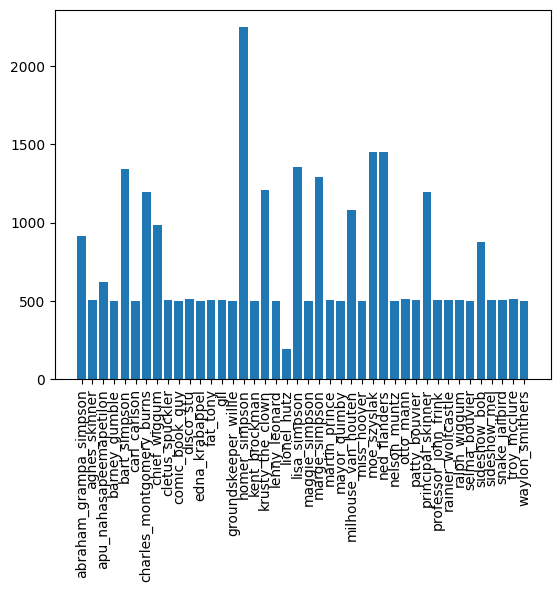

In [13]:
print_classes_graph(train_dir)

In [14]:
def calculate_mean_std(filenames):
    num_channels = 3
    dataset_mean = torch.zeros(num_channels)
    dataset_std = torch.zeros(num_channels)
    num_images = len(filenames)
    print('==> Computing mean and std..')
    for filename in tqdm(filenames):
        ToTensor = transforms.ToTensor()
        image_tensor = ToTensor(Image.open(filename))
        for i in range(num_channels):
            dataset_mean[i] += image_tensor[i, :, :].mean()
            dataset_std[i] += image_tensor[i, :, :].std()
    dataset_mean.div_(num_images)
    dataset_std.div_(num_images)
    print(f"Mean: {dataset_mean}")
    print(f"std: {dataset_std}")
    return dataset_mean, dataset_std

In [15]:
# files_training = list_of_files(train_dir, with_aug=False)
# result = calculate_mean_std(files_training)
total_mean, total_std = torch.tensor([0.4298, 0.3888, 0.3424]), torch.tensor([0.2325, 0.2168, 0.2363])
no_aug_mean, no_aug_std = torch.tensor([0.4622, 0.4075, 0.3524]), torch.tensor([0.2167, 0.1961, 0.2246])


In [16]:
from sklearn.model_selection import train_test_split

dataset_transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize(mean=total_mean, std=total_std)])
images_dataset = datasets.ImageFolder(
    root=train_dir, transform=dataset_transform
)

In [17]:
from torch.utils.data import SubsetRandomSampler


def get_loaders(dataset, batch_size=16):
    length = len(dataset)
    indicies = list(range(length))
    train_ind, val_ind = train_test_split(indicies, train_size=0.9, stratify=dataset.targets, shuffle=True, random_state=42)
    train_sampler = SubsetRandomSampler(train_ind)
    valid_sampler = SubsetRandomSampler(val_ind)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    return train_loader, validation_loader


In [18]:
num_epochs = 300
learning_rate = 0.001
batch_size = 16
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
min_valid_loss = np.inf

In [19]:
model = torchvision.models.resnet50(pretrained=False)
model_filename = "saved_model.pth"
if model_filename in os.listdir():
    model.load_state_dict(torch.load(model_filename))

# Set the model to run on the device
model = model.to(device)

train_loader, validation_loader = get_loaders(images_dataset, batch_size=batch_size)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

C:\Users\79137\PycharmProjects\Simpsons\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\79137\PycharmProjects\Simpsons\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
# for inputs, labels in train_loader:
#     size = sys.getsizeof(inputs) + torch.numel(inputs)*inputs.element_size()
#     print(size)
#     size = sys.getsizeof(labels) + torch.numel(labels)*labels.element_size()
#     print(size)
#     break

In [21]:
# def _get_memory_info(info_name, unit):
# 
#   tab = '\t'
#   if info_name == 'memory_allocated':
#     current_value = torch.cuda.memory.memory_allocated()
#   elif info_name == 'max_memory_allocated':
#     current_value = torch.cuda.memory.max_memory_allocated()
#   elif info_name == 'memory_reserved':
#     tab = '\t\t'
#     current_value = torch.cuda.memory.memory_reserved()
#   elif info_name == 'max_memory_reserved':
#     current_value = torch.cuda.memory.max_memory_reserved()
#   else:
#     raise ValueError()
#   return current_value
# def print_memory_info(unit='kb'):
# 
#   print(_get_memory_info('memory_allocated', unit))
#   print(_get_memory_info('max_memory_allocated', unit))
#   print(_get_memory_info('memory_reserved', unit))
#   print(_get_memory_info('max_memory_reserved', unit))
#   print('')

In [22]:

# Train the model...
for epoch in range(num_epochs):
    print(f"Running {epoch + 1} epoch")
    train_loss = 0.0
    model.train()
    for inputs, labels in tqdm(train_loader):
        # Move input and label tensors to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss = loss.item() * inputs.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
    valid_loss = 0.0
    model.eval()  # Optional when not using Model Specific layer
    for inputs, labels in tqdm(validation_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        target = model(inputs)
        loss = criterion(target, labels)
        valid_loss = loss.item() * inputs.size(0)
    # Print the loss for every epoch
    print(
        f'Epoch {epoch + 1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

print(f'Finished Training, Loss: {loss.item():.4f}')

Running 1 epoch


100%|██████████| 194/194 [00:29<00:00,  6.60it/s]


Epoch 1 		 Training Loss: 0.014835774249538651 		 Validation Loss: 0.20425496396330214
Validation Loss Decreased(inf--->39.625463) 	 Saving The Model
Running 2 epoch


100%|██████████| 194/194 [00:29<00:00,  6.60it/s]


Epoch 2 		 Training Loss: 0.006255006107013341 		 Validation Loss: 0.11673094685544673
Validation Loss Decreased(39.625463--->22.645804) 	 Saving The Model
Running 3 epoch


100%|██████████| 194/194 [00:31<00:00,  6.24it/s]


Epoch 3 		 Training Loss: 0.0063622305249757954 		 Validation Loss: 0.09645816100012396
Validation Loss Decreased(22.645804--->18.712883) 	 Saving The Model
Running 4 epoch


100%|██████████| 194/194 [00:31<00:00,  6.17it/s]


Epoch 4 		 Training Loss: 0.00912074769465493 		 Validation Loss: 0.06376545576705146
Validation Loss Decreased(18.712883--->12.370498) 	 Saving The Model
Running 5 epoch


100%|██████████| 194/194 [00:34<00:00,  5.59it/s]


Epoch 5 		 Training Loss: 0.0066707174552545845 		 Validation Loss: 0.0511642897251955
Validation Loss Decreased(12.370498--->9.925872) 	 Saving The Model
Running 6 epoch


100%|██████████| 194/194 [00:32<00:00,  6.05it/s]


Epoch 6 		 Training Loss: 0.00249807037050198 		 Validation Loss: 0.08530064096155855
Running 7 epoch


100%|██████████| 194/194 [00:32<00:00,  6.00it/s]


Epoch 7 		 Training Loss: 0.004537870651671401 		 Validation Loss: 0.06825029665661841
Running 8 epoch


100%|██████████| 194/194 [00:29<00:00,  6.68it/s]


Epoch 8 		 Training Loss: 0.00020238884796727353 		 Validation Loss: 0.015526832686257116
Validation Loss Decreased(9.925872--->3.012206) 	 Saving The Model
Running 9 epoch


100%|██████████| 194/194 [00:30<00:00,  6.29it/s]


Epoch 9 		 Training Loss: 0.0030220229167992885 		 Validation Loss: 0.018200699508804635
Running 10 epoch


100%|██████████| 194/194 [00:35<00:00,  5.44it/s]


Epoch 10 		 Training Loss: 0.00011314868948350322 		 Validation Loss: 0.05807652055602713
Running 11 epoch


100%|██████████| 194/194 [00:35<00:00,  5.49it/s]


Epoch 11 		 Training Loss: 0.0005313291206400853 		 Validation Loss: 0.07036293843357834
Running 12 epoch


100%|██████████| 194/194 [00:31<00:00,  6.20it/s]


Epoch 12 		 Training Loss: 0.00032317544464395515 		 Validation Loss: 0.019505080181298796
Running 13 epoch


100%|██████████| 194/194 [00:36<00:00,  5.35it/s]


Epoch 13 		 Training Loss: 0.0004719300264956958 		 Validation Loss: 0.04390446979974963
Running 14 epoch


100%|██████████| 194/194 [00:45<00:00,  4.29it/s]


Epoch 14 		 Training Loss: 0.00213857428050656 		 Validation Loss: 0.025167845880862363
Running 15 epoch


 36%|███▌      | 626/1745 [05:12<09:18,  2.00it/s]


KeyboardInterrupt: 

In [22]:
images_dataset.class_to_idx

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

Total classes: 42
Items per class:
abraham_grampa_simpson 48
agnes_skinner 0
apu_nahasapeemapetilon 50
barney_gumble 0
bart_simpson 50
carl_carlson 0
charles_montgomery_burns 48
chief_wiggum 50
cletus_spuckler 0
comic_book_guy 49
disco_stu 0
edna_krabappel 50
fat_tony 0
gil 0
groundskeeper_willie 0
homer_simpson 50
kent_brockman 50
krusty_the_clown 50
lenny_leonard 50
lionel_hutz 0
lisa_simpson 50
maggie_simpson 0
marge_simpson 50
martin_prince 0
mayor_quimby 50
milhouse_van_houten 49
miss_hoover 0
moe_szyslak 50
ned_flanders 49
nelson_muntz 50
otto_mann 0
patty_bouvier 0
principal_skinner 50
professor_john_frink 0
rainier_wolfcastle 0
ralph_wiggum 0
selma_bouvier 0
sideshow_bob 47
sideshow_mel 0
snake_jailbird 0
troy_mcclure 0
waylon_smithers 0


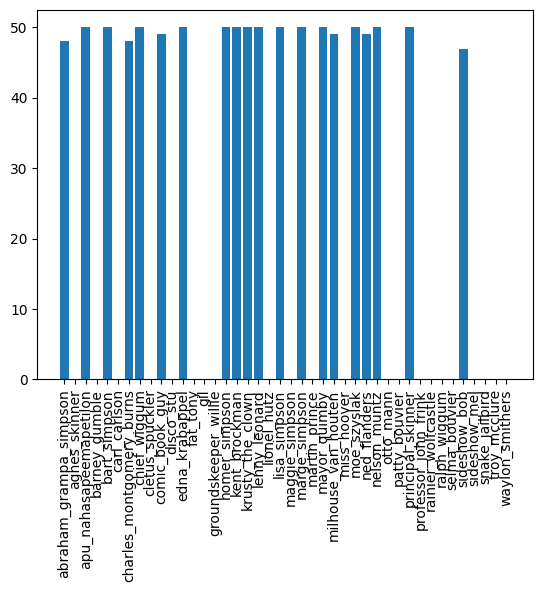

In [25]:
print_classes_graph(test_dir)

In [26]:
test_dataset = datasets.ImageFolder(
    root=test_dir, transform=dataset_transform
)

In [30]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True)

In [44]:
y_true = []
y_pred = []
with torch.no_grad():
    model.eval()
    for inputs, labels in tqdm(test_loader):
        y_true.extend(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        
        outputs = outputs
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())


100%|██████████| 62/62 [00:07<00:00,  7.78it/s]


In [45]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [46]:
dataframe = pd.DataFrame(cf_matrix, index=test_dataset.targets, columns=test_dataset.targets)

ValueError: Shape of passed values is (30, 30), indices imply (990, 990)